In [1]:
# OLD BIRD

import numpy as np
import os
import pandas as pd
import sys
sys.path.append("../src")
import localmodule

dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
models_dir = localmodule.get_models_dir()
model_name = "oldbird"
model_dir = os.path.join(models_dir, model_name)
units = localmodule.get_units()
tolerance_ms = 500
tol_str = "tol-" + str(tolerance_ms)
prefix = "_".join([dataset_name, "oldbird_merged_clip-suppressor"])
n_thresholds = 100

unit_relevant = []
unit_selected, unit_tp = [], []

tp_matrix = np.zeros((n_thresholds, n_units))
fp_matrix = np.zeros((n_thresholds, n_units))
fn_matrix = np.zeros((n_thresholds, n_units))

for unit_id, unit_str in enumerate(units):
    unit_dir = os.path.join(model_dir, unit_str)
    metrics_name = "_".join([prefix, unit_str, tol_str, "metrics"])
    metrics_path = os.path.join(unit_dir, metrics_name + ".csv")
    df = pd.read_csv(metrics_path)
    true_positives = np.array(df["True positives"])
    tp_matrix[:, unit_id] = true_positives
    false_positives = np.array(df["False positives"])
    fp_matrix[:, unit_id] = false_positives
    false_negatives = np.array(df["False negatives"])
    fn_matrix[:, unit_id] = false_negatives
    
    
oldbird_tp = np.sum(tp_matrix, axis=1)
oldbird_fp = np.sum(fp_matrix, axis=1)
oldbird_fn = np.sum(fn_matrix, axis=1)

eps = np.finfo(float).eps
oldbird_precisions = oldbird_tp / (eps+oldbird_tp+oldbird_fp)
oldbird_recalls = oldbird_tp / (eps+oldbird_tp+oldbird_fn)

sorting_indices = np.argsort(oldbird_recalls)
oldbird_precisions = oldbird_precisions[sorting_indices]
oldbird_recalls = oldbird_recalls[sorting_indices]

oldbird_f1_scores = 2*oldbird_precisions*oldbird_recalls / (eps+oldbird_precisions+oldbird_recalls)

In [2]:
oldbird_f1_scores

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.00017007,
        0.02736394,  0.05070929,  0.05136589,  0.05197669,  0.05217482,
        0.05235165,  0.05232528,  0.05282823,  0.05261254,  0.05226018,
        0.0529448 ,  0.05267179,  0.05362392,  0.05362282,  0.05431503,
        0.05427599,  0.03976172,  0.05429909,  0.05488561,  0.05483919,
        0.05580664,  0.05618252,  0.05613113,  0.0563285 ,  0.05651672,
        0.05667784,  0.0570912 ,  0.05681066,  0.05717505,  0.05787361,
        0.05787542,  0.05748558,  0.05719759,  0.05785806,  0.05825067,
        0.0589083 ,  0.05898411,  0.0592724 ,  0.05901784,  0.05862793,
        0.05852473,  0.05847051,  0.05928035,  0.05901333,  0.05998149,
        0.06102174,  0.06122953,  0.060991  ,  0.06070133,  0.06155443,
        0.06231712,  0.06301252,  0.0641939 ,  0.06491618,  0.06539345,
        0.06640205,  0.067572  ,  0.06816394,  0.06754617,  0.06671496,
        0.06661923,  0.06685624,  0.06669689,  0.06632347,  0.06

In [3]:
# SPECTRAL FLUX
import h5py
import mir_eval
import numpy as np
import os
import pandas as pd
import peakutils
import sys
from tqdm import tqdm
sys.path.append('../src')
import localmodule


# Define directory of spectral flux ODFs.
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
units = localmodule.get_units()
n_units = len(units)
sf_dir = os.path.join(data_dir,
    "_".join([dataset_name, "spectral-flux"]))


# Define constants.
sf_sr = 22050
sf_hop_length = 512
n_thresholds = 100
min_dist = 4
tolerance = 0.5


# Define array of thresholds.
thresholds = np.linspace(0.0, 0.5, n_thresholds)


# Define directory for annotations.
annotations_name = "_".join([dataset_name, "annotations"])
annotations_dir = os.path.join(data_dir, annotations_name)


tp_matrix = np.zeros((n_thresholds, n_units))
fp_matrix = np.zeros((n_thresholds, n_units))
fn_matrix = np.zeros((n_thresholds, n_units))


# Loop over units.
for unit_id, unit_str in enumerate(units):

    # Load onset detection function.
    odf_path = os.path.join(sf_dir, unit_str + ".hdf5")
    odf_file = h5py.File(odf_path, "r")
    odf = odf_file["spectral-flux_odf"].value
    odf = np.ravel(odf)
    odf_file.close()

    # Load annotation.
    annotation_path = os.path.join(
        annotations_dir, unit_str + ".txt")
    annotation = pd.read_csv(annotation_path, '\t')
    begin_times = np.array(annotation["Begin Time (s)"])
    end_times = np.array(annotation["End Time (s)"])
    relevant = 0.5 * (begin_times + end_times)
    relevant = np.sort(relevant)
    n_relevant = len(relevant)

    # Loop over thresholds.
    for th_id, threshold in tqdm(enumerate(thresholds)):
        # Pick peaks.
        peak_locs = peakutils.indexes(
            odf, thres=threshold, min_dist=4)
        selected = peak_locs * sf_hop_length / sf_sr
        selected_relevant = mir_eval.util.match_events(
            relevant, selected, tolerance)
        
        true_positives = len(selected_relevant)
        n_selected = len(selected)
        false_positives = n_selected - true_positives
        false_negatives = n_relevant - true_positives

        tp_matrix[th_id, unit_id] = true_positives
        fp_matrix[th_id, unit_id] = false_positives
        fn_matrix[th_id, unit_id] = false_negatives
        
sf_total_tps = np.sum(tp_matrix, axis=1)
sf_total_fps = np.sum(fp_matrix, axis=1)
sf_total_fns = np.sum(fn_matrix, axis=1)

sf_total_precisions = 100.0 * sf_total_tps / (sf_total_tps + sf_total_fps)
sf_total_precisions = sf_total_precisions[::-1]
sf_total_recalls = 100.0 * sf_total_tps / (sf_total_tps + sf_total_fns)
sf_total_recalls = sf_total_recalls[::-1]
sf_total_f1_scores = (2*sf_total_precisions*sf_total_recalls) / (sf_total_precisions+sf_total_recalls)

12it [00:20,  1.67s/it]

KeyboardInterrupt: 

In [67]:
# ICASSP CONVNET

import numpy as np
import os
import pandas as pd
import scipy.interpolate
import sklearn.metrics
import sys
sys.path.append("../src")
import localmodule


from matplotlib import pyplot as plt
%matplotlib inline

# Define constants.
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
n_thresholds = 221
n_trials = 10
n_eval_trials = 5


# Initialize dicts.
report = {}


# Loop over augmentations.
for aug_kind_str in ["none", "all"]:

    # Initialize dictionaries
    aug_report = {
        "validation": {},
        "test-CV-AUPRC": {},
        "test-CV-F": {},
        "test-oracle-AUPRC": {},
        "test-oracle-F": {},
    }


    val_precisions = np.zeros((n_units, n_trials))
    val_recalls = np.zeros((n_units, n_trials))
    val_f1_scores = np.zeros((n_units, n_trials))
    val_auprcs = np.zeros((n_units, n_trials))
    val_thresholds = np.zeros((n_units, n_trials))
    val_threshold_ids = np.zeros((n_units, n_trials))


    thresholds = 1.0 - np.concatenate((
        np.logspace(-9, -2, 141), np.delete(np.logspace(-2, 0, 81), 0)
    ))
    n_thresholds = len(thresholds)


    # Define model directory
    model_name = "icassp-convnet"
    if not aug_kind_str == "none":
        model_name = "_".join([model_name, "aug-" + aug_kind_str])
    model_dir = os.path.join(models_dir, model_name)


    # Loop over test units.
    for test_unit_id in range(n_units):

        test_unit_str = units[test_unit_id]
        test_unit_dir = os.path.join(model_dir, test_unit_str)

        # Retrieve fold such that unit_str is in the test set.
        folds = localmodule.fold_units()
        fold = [f for f in folds if test_unit_str in f[0]][0]
        test_units = fold[0]
        validation_units = fold[2]

        # Loop over trials.
        for trial_id in range(n_trials):

            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)
            break_switch = False

            # Loop over validation units.
            for predict_unit_str in validation_units:
                val_metrics_name = "_".join([
                    dataset_name,
                    model_name,
                    "test-" + test_unit_str,
                    trial_str,
                    "predict-" + predict_unit_str,
                    "full-audio-metrics.csv"
                ])
                val_metrics_path = os.path.join(trial_dir, val_metrics_name)
                val_tp = np.zeros((n_thresholds,))
                val_fp = np.zeros((n_thresholds,))
                val_fn = np.zeros((n_thresholds,))
                try:
                    val_metrics_df = pd.read_csv(val_metrics_path)
                    val_tp = val_tp + np.array(val_metrics_df["True positives"])
                    val_fp = val_fp + np.array(val_metrics_df["False positives"])
                    val_fn = val_fn + np.array(val_metrics_df["False negatives"])
                except:
                    break_switch = True
                    break

            if break_switch:
                val_auprc = 0.0
                val_p = np.zeros((n_thresholds,))
                val_r = np.zeros((n_thresholds,))
                val_f = np.zeros((n_thresholds,))
                val_threshold_id = 0
            else:
                val_p = val_tp / (np.finfo(float).eps + val_tp + val_fp)
                val_r = val_tp / (np.finfo(float).eps + val_tp + val_fn)
                val_f = 2*val_p*val_r / (np.finfo(float).eps+(val_p+val_r))
                val_threshold_id = np.argmax(val_f)
                val_p_ = np.array([1.0] + list(val_p) + [0.0])
                val_r_ = np.array([0.0] + list(val_r) + [1.0])
                val_auprc = sklearn.metrics.auc(val_r_, val_p_, reorder=True)

            val_precisions[test_unit_id, trial_id] = val_p[val_threshold_id]
            val_recalls[test_unit_id, trial_id] = val_r[val_threshold_id]
            val_f1_scores[test_unit_id, trial_id] = val_f[val_threshold_id]
            val_thresholds[test_unit_id, trial_id] = thresholds[val_threshold_id]
            val_threshold_ids[test_unit_id, trial_id] = val_threshold_id
            val_auprcs[test_unit_id, trial_id] = val_auprc


    aug_report["validation"]["P"] = val_precisions
    aug_report["validation"]["R"] = val_recalls
    aug_report["validation"]["F"] = val_f1_scores
    aug_report["validation"]["AUPRC"] = val_auprcs
    aug_report["validation"]["threshold"] = val_thresholds
    aug_report["validation"]["threshold_ids"] = val_threshold_ids
    aug_report["validation"]["trials_F"] = np.argsort(val_f1_scores, axis=1)
    aug_report["validation"]["trials_AUPRC"] = np.argsort(val_auprcs, axis=1)


    # Loop over test trials.
    auprc_eval_trials = np.sort(aug_report["validation"]["trials_AUPRC"][:, -5:], axis=1)
    test_auprcs = np.zeros((n_eval_trials,))
    test_precisions = np.zeros((n_thresholds, n_eval_trials))
    test_recalls = np.zeros((n_thresholds, n_eval_trials))
    test_f1_scores = np.zeros((n_thresholds, n_eval_trials))

    for eval_trial_id in range(n_eval_trials):
        test_tp = np.zeros((n_thresholds,))
        test_fp = np.zeros((n_thresholds,))
        test_fn = np.zeros((n_thresholds,))

        for test_unit_id in range(n_units):
            test_unit_str = units[test_unit_id]
            test_unit_dir = os.path.join(model_dir, test_unit_str)
            trial_id = auprc_eval_trials[test_unit_id, eval_trial_id]
            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)

            # Load test predictions.
            test_metrics_name = "_".join([
                dataset_name,
                model_name,
                "test-" + test_unit_str,
                trial_str,
                "predict-" + test_unit_str,
                "full-audio-metrics.csv"
            ])
            test_metrics_path = os.path.join(trial_dir, test_metrics_name)
            test_metrics_df = pd.read_csv(test_metrics_path)
            test_tp = test_tp + np.array(test_metrics_df["True positives"])
            test_fp = test_fp + np.array(test_metrics_df["False positives"])
            test_fn = test_fn + np.array(test_metrics_df["False negatives"])
        
        test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
        test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
        test_p_ = np.array([1.0] + list(test_p) + [0.0])
        test_r_ = np.array([0.0] + list(test_r) + [1.0])
        test_auprc = sklearn.metrics.auc(test_r_, test_p_, reorder=True)

        test_auprcs[eval_trial_id] = test_auprc
        test_precisions[:, eval_trial_id] = test_p
        test_recalls[:, eval_trial_id] = test_r
        test_f1_scores[:, eval_trial_id] =\
            (2*test_p*test_r) / (np.finfo(float).eps+test_p+test_r)
            


    aug_report["test-CV-AUPRC"]["AUPRC"] = test_auprcs
    aug_report["test-CV-AUPRC"]["P"] = test_precisions
    aug_report["test-CV-AUPRC"]["R"] = test_recalls
    aug_report["test-CV-AUPRC"]["F"] = test_f1_scores


    all_test_recalls = np.array(list(np.sort(np.ravel(test_recalls))))
    interpolated_precisions = np.zeros((2 + len(all_test_recalls), n_eval_trials))

    for eval_trial_id in range(n_eval_trials):
        precision_interpolator = scipy.interpolate.interp1d(
            np.array([0.0] + list(test_recalls[:, eval_trial_id]) + [1.0]),
            np.array([1.0] + list(test_precisions[:, eval_trial_id]) + [1.0]))
        interpolated_precisions[:, eval_trial_id] =\
            np.array([1.0] + list(precision_interpolator(all_test_recalls)) + [0.0])

    interpolated_recalls = np.array([0.0] + list(all_test_recalls) + [1.0])
    aug_report["test-CV-AUPRC"]["interpolated_P"] = np.sort(interpolated_precisions, axis=1)
    aug_report["test-CV-AUPRC"]["interpolated_R"] = interpolated_recalls
    aug_report["test-CV-AUPRC"]["interpolated_F"] =\
        (2*aug_report["test-CV-AUPRC"]["interpolated_P"]*aug_report["test-CV-AUPRC"]["interpolated_R"][:, np.newaxis]) /\
        (aug_report["test-CV-AUPRC"]["interpolated_P"]+aug_report["test-CV-AUPRC"]["interpolated_R"][:, np.newaxis])


    # Estimate F1 score.
    f_eval_trials = np.sort(aug_report["validation"]["trials_F"][:, -5:], axis=1)
    test_precisions = np.zeros((n_eval_trials,))
    test_recalls = np.zeros((n_eval_trials,))
    test_f1_scores = np.zeros((n_eval_trials,))

    for eval_trial_id in range(n_eval_trials):
        test_tp = 0
        test_fp = 0
        test_fn = 0

        for test_unit_id in range(n_units):
            test_unit_str = units[test_unit_id]
            test_unit_dir = os.path.join(model_dir, test_unit_str)
            trial_id = f_eval_trials[test_unit_id, eval_trial_id]
            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)
            
            threshold_id = int(aug_report["validation"]["threshold_ids"][
                test_unit_id, trial_id])

            # Load test predictions.
            test_metrics_name = "_".join([
                dataset_name,
                model_name,
                "test-" + test_unit_str,
                trial_str,
                "predict-" + test_unit_str,
                "full-audio-metrics.csv"
            ])
            test_metrics_path = os.path.join(trial_dir, test_metrics_name)
            test_metrics_df = pd.read_csv(test_metrics_path)
            test_tp = test_tp + np.array(test_metrics_df["True positives"])[threshold_id]
            test_fp = test_fp + np.array(test_metrics_df["False positives"])[threshold_id]
            test_fn = test_fn + np.array(test_metrics_df["False negatives"])[threshold_id]

        test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
        test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
        test_f = 2*test_p*test_r / (np.finfo(float).eps+test_p+test_r)

        test_precisions[eval_trial_id] = test_p
        test_recalls[eval_trial_id] = test_r
        test_f1_scores[eval_trial_id] =\
            (2*test_p*test_r) / (np.finfo(float).eps+test_p+test_r)
            
    aug_report["test-CV-F"]["P"] = test_precisions
    aug_report["test-CV-F"]["R"] = test_recalls
    aug_report["test-CV-F"]["F"] = test_f1_scores
    
    report[aug_kind_str] = aug_report

18.24 57.03 65.56 45.58 66.41 63.65
Fixed th: 37.68%
Oracle th: 52.74%


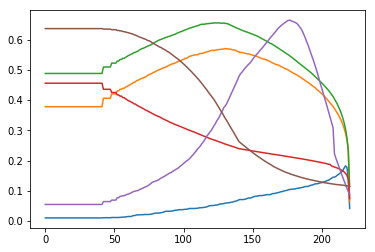

In [63]:
# ICASSP CONVNET (none) BY UNITS
aug_kind_str = "none"
model_name = "icassp-convnet"
if not aug_kind_str == "none":
    model_name = "_".join([model_name, "aug-" + aug_kind_str])
model_dir = os.path.join(models_dir, model_name)
test_fs = []
for test_unit_id in range(n_units):
    test_unit_str = units[test_unit_id]
    test_unit_dir = os.path.join(model_dir, test_unit_str)
    if test_unit_id in [0]:
        trial_id = [3][test_unit_id]
    else:
        trial_id = auprc_eval_trials[test_unit_id, eval_trial_id]
    trial_str = "trial-" + str(trial_id)
    trial_dir = os.path.join(test_unit_dir, trial_str)

    # Load test predictions.
    test_metrics_name = "_".join([
        dataset_name,
        model_name,
        "test-" + test_unit_str,
        trial_str,
        "predict-" + test_unit_str,
        "full-audio-metrics.csv"
    ])
    test_metrics_path = os.path.join(trial_dir, test_metrics_name)
    test_metrics_df = pd.read_csv(test_metrics_path)
    test_tp = np.array(test_metrics_df["True positives"])
    test_fp = np.array(test_metrics_df["False positives"])
    test_fn = np.array(test_metrics_df["False negatives"])
    
    test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
    test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
    test_f = 2*test_p*test_r / (np.finfo(float).eps+test_p+test_r)
    test_fs.append(test_f)
    
plt.plot(np.array(test_fs).T);

print(" ".join(["{:5.2f}".format(100 * np.max(np.array(test_fs), axis=1)[i]) for i in range(6)]))
print("Fixed th: {:5.2f}%".format(100 * np.max(np.mean(np.array(test_fs), axis=0))))
print("Oracle th: {:5.2f}%".format(100 * np.mean(np.max(np.array(test_fs), axis=1))))

55.41 61.13 69.07 47.77 81.34 73.63
Fixed th: 59.15%
Oracle th: 64.73%


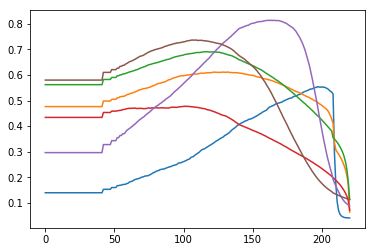

In [69]:
# ICASSP CONVNET (all) BY UNITS
aug_kind_str = "all"
model_name = "icassp-convnet"
if not aug_kind_str == "none":
    model_name = "_".join([model_name, "aug-" + aug_kind_str])
model_dir = os.path.join(models_dir, model_name)
test_fs = []
for test_unit_id in range(n_units):
    test_unit_str = units[test_unit_id]
    test_unit_dir = os.path.join(model_dir, test_unit_str)
    trial_id = auprc_eval_trials[test_unit_id, eval_trial_id]
    trial_str = "trial-" + str(trial_id)
    trial_dir = os.path.join(test_unit_dir, trial_str)

    # Load test predictions.
    test_metrics_name = "_".join([
        dataset_name,
        model_name,
        "test-" + test_unit_str,
        trial_str,
        "predict-" + test_unit_str,
        "full-audio-metrics.csv"
    ])
    test_metrics_path = os.path.join(trial_dir, test_metrics_name)
    test_metrics_df = pd.read_csv(test_metrics_path)
    test_tp = np.array(test_metrics_df["True positives"])
    test_fp = np.array(test_metrics_df["False positives"])
    test_fn = np.array(test_metrics_df["False negatives"])
    
    test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
    test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
    test_f = 2*test_p*test_r / (np.finfo(float).eps+test_p+test_r)
    test_fs.append(test_f)
    

plt.plot(np.array(test_fs).T);

print(" ".join(["{:5.2f}".format(100 * np.max(np.array(test_fs), axis=1)[i]) for i in range(6)]))
print("Fixed th: {:5.2f}%".format(100 * np.max(np.mean(np.array(test_fs), axis=0))))
print("Oracle th: {:5.2f}%".format(100 * np.mean(np.max(np.array(test_fs), axis=1))))

63.63 57.28 66.76 53.15 75.28 69.41
Fixed th: 60.32%
Oracle th: 64.25%


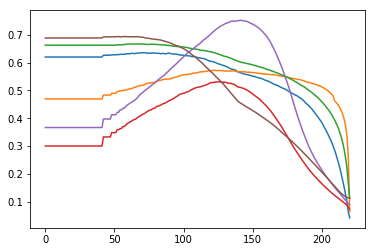

In [66]:
# PCEN CONVNET (none) BY UNITS
aug_kind_str = "none"
model_name = "pcen-convnet"
if not aug_kind_str == "none":
    model_name = "_".join([model_name, "aug-" + aug_kind_str])
model_dir = os.path.join(models_dir, model_name)
test_fs = []

for test_unit_id in range(n_units):
    test_unit_str = units[test_unit_id]
    test_unit_dir = os.path.join(model_dir, test_unit_str)
    trial_id = [3, 1, 6, 1, 4, 6][test_unit_id]
    trial_str = "trial-" + str(trial_id)
    trial_dir = os.path.join(test_unit_dir, trial_str)

    # Load test predictions.
    test_metrics_name = "_".join([
        dataset_name,
        model_name,
        "test-" + test_unit_str,
        trial_str,
        "predict-" + test_unit_str,
        "full-audio-metrics.csv"
    ])
    test_metrics_path = os.path.join(trial_dir, test_metrics_name)
    test_metrics_df = pd.read_csv(test_metrics_path)
    test_tp = np.array(test_metrics_df["True positives"])
    test_fp = np.array(test_metrics_df["False positives"])
    test_fn = np.array(test_metrics_df["False negatives"])
    
    test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
    test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
    test_f = 2*test_p*test_r / (np.finfo(float).eps+test_p+test_r)
    
    test_fs.append(test_f)
    
plt.plot(np.array(test_fs).T);


print(" ".join(["{:5.2f}".format(100 * np.max(np.array(test_fs), axis=1)[i]) for i in range(6)]))
print("Fixed th: {:5.2f}%".format(100 * np.max(np.mean(np.array(test_fs), axis=0))))
print("Oracle th: {:5.2f}%".format(100 * np.mean(np.max(np.array(test_fs), axis=1))))

67.15 59.88 68.61 50.64 76.93 75.65
Fixed th: 61.63%
Oracle th: 66.48%


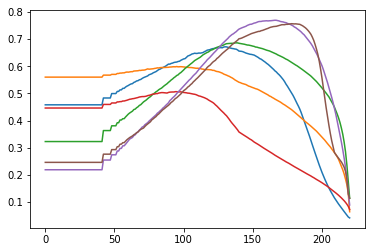

In [12]:
# PCEN CONVNET (all) BY UNITS
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
import sys

sys.path.append("../src")
import localmodule

dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
models_dir = localmodule.get_models_dir()

aug_kind_str = "all"
model_name = "pcen-convnet"
if not aug_kind_str == "none":
    model_name = "_".join([model_name, "aug-" + aug_kind_str])
model_dir = os.path.join(models_dir, model_name)
test_fs = []

for test_unit_id in range(n_units):
    test_unit_str = units[test_unit_id]
    test_unit_dir = os.path.join(model_dir, test_unit_str)
    trial_id = [0, 3, 5, 2, 1, 1][test_unit_id]
    trial_str = "trial-" + str(trial_id)
    trial_dir = os.path.join(test_unit_dir, trial_str)

    # Load test predictions.
    test_metrics_name = "_".join([
        dataset_name,
        model_name,
        "test-" + test_unit_str,
        trial_str,
        "predict-" + test_unit_str,
        "full-audio-metrics.csv"
    ])
    test_metrics_path = os.path.join(trial_dir, test_metrics_name)
    test_metrics_df = pd.read_csv(test_metrics_path)
    test_tp = np.array(test_metrics_df["True positives"])
    test_fp = np.array(test_metrics_df["False positives"])
    test_fn = np.array(test_metrics_df["False negatives"])
    
    test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
    test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
    test_f = 2*test_p*test_r / (np.finfo(float).eps+test_p+test_r)
    
    test_fs.append(test_f)
 

%matplotlib inline
plt.plot(np.array(test_fs).T);


print(" ".join(["{:5.2f}".format(100 * np.max(np.array(test_fs), axis=1)[i]) for i in range(6)]))
print("Fixed th: {:5.2f}%".format(100 * np.max(np.mean(np.array(test_fs), axis=0))))
print("Oracle th: {:5.2f}%".format(100 * np.mean(np.max(np.array(test_fs), axis=1))))

 0.35  0.82  0.45  0.00  0.75  7.00
Fixed th:  1.40%
Oracle th:  1.56%


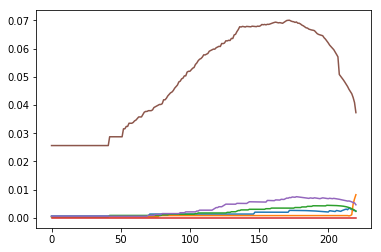

In [68]:
# NTT CONVNET (all) BY UNITS
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
import sys

sys.path.append("../src")
import localmodule

dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
models_dir = localmodule.get_models_dir()

aug_kind_str = "all"
model_name = "icassp-ntt-convnet"
if not aug_kind_str == "none":
    model_name = "_".join([model_name, "aug-" + aug_kind_str])
model_dir = os.path.join(models_dir, model_name)
test_fs = []

for test_unit_id in range(n_units):
    test_unit_str = units[test_unit_id]
    test_unit_dir = os.path.join(model_dir, test_unit_str)
    trial_id = [0, 0, 0, 4, 0, 0][test_unit_id]
    trial_str = "trial-" + str(trial_id)
    trial_dir = os.path.join(test_unit_dir, trial_str)

    # Load test predictions.
    test_metrics_name = "_".join([
        dataset_name,
        model_name,
        "test-" + test_unit_str,
        trial_str,
        "predict-" + test_unit_str,
        "full-audio-metrics.csv"
    ])
    test_metrics_path = os.path.join(trial_dir, test_metrics_name)
    test_metrics_df = pd.read_csv(test_metrics_path)
    test_tp = np.array(test_metrics_df["True positives"])
    test_fp = np.array(test_metrics_df["False positives"])
    test_fn = np.array(test_metrics_df["False negatives"])
    
    test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
    test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
    test_f = 2*test_p*test_r / (np.finfo(float).eps+test_p+test_r)
    
    test_fs.append(test_f)
 

%matplotlib inline
plt.plot(np.array(test_fs).T);


print(" ".join(["{:5.2f}".format(100 * np.max(np.array(test_fs), axis=1)[i]) for i in range(6)]))
print("Fixed th: {:5.2f}%".format(100 * np.max(np.mean(np.array(test_fs), axis=0))))
print("Oracle th: {:5.2f}%".format(100 * np.mean(np.max(np.array(test_fs), axis=1))))

In [45]:
import csv
import numpy as np
import os
import pandas as pd
import sys
sys.path.append("../src")
import localmodule
import mir_eval
import peakutils
import tqdm

data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
models_dir = localmodule.get_models_dir()

model_name = "skm-cv"
skm_dir = os.path.join(models_dir, "skm-cv")
n_trials = 5
icassp_thresholds = 1.0 - np.concatenate((
    np.logspace(-9, -2, 81), np.delete(np.logspace(-2, 0, 11), 0)
))
icassp_thresholds = icassp_thresholds
n_thresholds = len(icassp_thresholds)
tolerance = 0.5 # in seconds
min_dist = 3 # 150 ms
aug_kind_str = "none"

for test_unit_id in range(n_units):

    test_unit_str = units[test_unit_id]
    test_unit_dir = os.path.join(skm_dir, test_unit_str)


    # Retrieve fold such that unit_str is in the test set.
    folds = localmodule.fold_units()
    fold = [f for f in folds if test_unit_str in f[0]][0]
    test_units = fold[0]
    training_units = fold[1]
    validation_units = fold[2]
    predict_units = test_units + validation_units


    # Loop over prediction units.
    predict_unit_str = test_unit_str
    #for predict_unit_str in predict_units:


    # Load annotation.
    annotations_name = "_".join([dataset_name, "annotations"])
    annotations_dir = os.path.join(data_dir, annotations_name)
    annotation_path = os.path.join(annotations_dir, predict_unit_str + ".txt")
    annotation = pd.read_csv(annotation_path, "\t")
    begin_times = np.array(annotation["Begin Time (s)"])
    end_times = np.array(annotation["End Time (s)"])
    relevant = 0.5 * (begin_times + end_times)
    relevant = np.sort(relevant)
    n_relevant = len(relevant)


    for trial_id in [0]:#range(n_trials):

        trial_str = "trial-" + str(trial_id + 5)
        trial_dir = os.path.join(test_unit_dir, trial_str)

        prediction_name = "_".join([
            dataset_name,
            model_name,
            "test-" + test_unit_str,
            trial_str,
            "predict-" + test_unit_str,
            "full-predictions"
        ])
        prediction_path = os.path.join(trial_dir, prediction_name + ".csv")
        prediction_df = pd.read_csv(prediction_path)
        odf = np.array(prediction_df["Predicted probability"])
        timestamps = np.array(prediction_df["Timestamp"])


        # Create CSV file for metrics.
        metrics_name = "_".join([
            dataset_name,
            model_name,
            "test-" + test_unit_str,
            trial_str,
            "predict-" + predict_unit_str,
            "full-audio-metrics"
        ])
        metrics_path = os.path.join(trial_dir, metrics_name + ".csv")
        csv_file = open(metrics_path, 'w')
        csv_writer = csv.writer(csv_file, delimiter=',')


        # Write CSV header.
        csv_header = [
            "Dataset",
            "Augmentation kind",
            "Test unit",
            "Trial",
            "Prediction unit",
            "Tolerance",
            "Threshold",
            "Relevant",
            "Selected",
            "True positives",
            "False positives",
            "False negatives",
            "Precision (%)",
            "Recall (%)",
            "F1 Score (%)"]
        csv_writer.writerow(csv_header)


        # Loop over thresholds.
        for threshold_id in tqdm.tqdm(range(n_thresholds)):
            threshold = icassp_thresholds[threshold_id]

            # Pick peaks.
            peak_locations = peakutils.indexes(
                odf, thres=threshold, min_dist=min_dist)
            peak_times = timestamps[peak_locations]
            peak_values = odf[peak_locations]
            selected = peak_times[peak_values > threshold]

            # Match events.
            selected_relevant = mir_eval.util.match_events(
                relevant, selected, tolerance)

            # Count TP, FP, and FN.
            true_positives = len(selected_relevant)
            n_selected = len(selected)
            false_positives = n_selected - true_positives
            false_negatives = n_relevant - true_positives

            # Compute precision, recall, and F1 score.
            if n_selected == 0 or true_positives == 0:
                precision = 0.0
                recall = 0.0
                f1_score = 0.0
            else:
                precision = 100 * true_positives / n_selected
                recall = 100 * true_positives / n_relevant
                f1_score = 2*precision*recall / (precision+recall)

            # Write row.
            row = [
                dataset_name,
                aug_kind_str,
                test_unit_str,
                str(trial_id),
                predict_unit_str,
                str(int(np.round(1000*tolerance))).rjust(4),
                format(threshold, ".10f"),
                str(n_relevant).rjust(5),
                str(n_selected).rjust(6),
                str(true_positives).rjust(5),
                str(false_positives).rjust(6),
                str(false_negatives).rjust(5),
                format(precision, ".6f").rjust(10),
                format(recall, ".6f").rjust(10),
                format(f1_score, ".6f").rjust(10)
            ]

            csv_writer.writerow(row)

        csv_file.close()

100%|██████████| 91/91 [00:12<00:00,  1.10s/it]


In [46]:
n_thresholds = 91
skm_fn = np.zeros((n_thresholds, n_units, n_trials))
skm_fp = np.zeros((n_thresholds, n_units, n_trials))
skm_tp = np.zeros((n_thresholds, n_units, n_trials))


for test_unit_id in range(n_units):
    print(test_unit_id)

    test_unit_str = units[test_unit_id]
    test_unit_dir = os.path.join(skm_dir, test_unit_str)


    # Retrieve fold such that unit_str is in the test set.
    folds = localmodule.fold_units()
    fold = [f for f in folds if test_unit_str in f[0]][0]
    test_units = fold[0]
    training_units = fold[1]
    validation_units = fold[2]
    predict_units = test_units + validation_units


    # Loop over prediction units.
    predict_unit_str = test_unit_str
    #for predict_unit_str in predict_units:


    # Load annotation.
    annotations_name = "_".join([dataset_name, "annotations"])
    annotations_dir = os.path.join(data_dir, annotations_name)
    annotation_path = os.path.join(annotations_dir, predict_unit_str + ".txt")
    annotation = pd.read_csv(annotation_path, "\t")
    begin_times = np.array(annotation["Begin Time (s)"])
    end_times = np.array(annotation["End Time (s)"])
    relevant = 0.5 * (begin_times + end_times)
    relevant = np.sort(relevant)
    n_relevant = len(relevant)

    trial_id = 0
    #for trial_id in range(n_trials):

    trial_str = "trial-" + str(trial_id + 5)
    trial_dir = os.path.join(test_unit_dir, trial_str)

    prediction_name = "_".join([
        dataset_name,
        model_name,
        "test-" + test_unit_str,
        trial_str,
        "predict-" + test_unit_str,
        "full-predictions"
    ])
    prediction_path = os.path.join(trial_dir, prediction_name + ".csv")
    prediction_df = pd.read_csv(prediction_path)
    odf = np.array(prediction_df["Predicted probability"])
    timestamps = np.array(prediction_df["Timestamp"])


    # Load metrics as Pandas dataframe.
    metrics_name = "_".join([
        dataset_name,
        model_name,
        "test-" + test_unit_str,
        trial_str,
        "predict-" + predict_unit_str,
        "full-audio-metrics"
    ])
    metrics_path = os.path.join(trial_dir, metrics_name + ".csv")

    metrics_df = pd.read_csv(metrics_path)
    
    skm_fn[:, test_unit_id, trial_id] = metrics_df["False negatives"]
    skm_fp[:, test_unit_id, trial_id] = metrics_df["False positives"]
    skm_tp[:, test_unit_id, trial_id] = metrics_df["True positives"]

0
1
2
3
4
5


In [62]:
skm_p = np.sum(skm_tp, axis=1) / (np.finfo(float).eps + np.sum(skm_tp, axis=1) + np.sum(skm_fp, axis=1))
skm_r = np.sum(skm_tp, axis=1) / (np.finfo(float).eps + np.sum(skm_tp, axis=1) + np.sum(skm_fn, axis=1))

In [63]:
skm_p.shape

(91, 5)

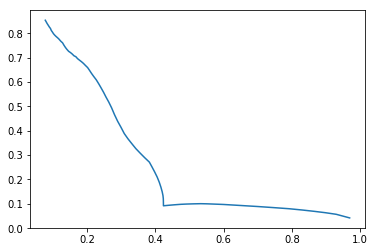

In [64]:
plt.plot(skm_r[:, 0], skm_p[:, 0])

In [107]:
skm_f = 2*skm_p*skm_r / (1e-16 + skm_p+skm_r)
skm_f

array([[ 0.116082  ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.12003373,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.12468802,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.12924751,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.13429151,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.13901321,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.14252609,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.14733597,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.15195657,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.1569627 ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.16209451,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.16766451,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.17323396,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.17868303,  0.        ,  0. 

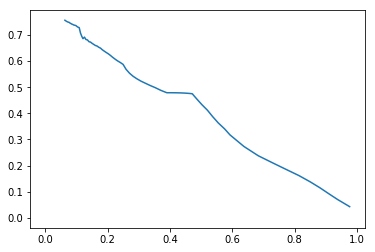

In [83]:
skm_p = skm_tp / (np.finfo(float).eps + skm_tp + skm_fp)
skm_r = skm_tp / (np.finfo(float).eps + skm_tp + skm_fn)
plt.plot(np.mean(skm_r, axis=1), np.mean(skm_p, axis=1))

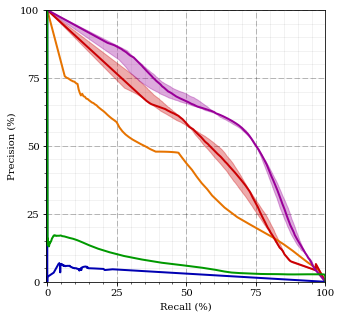

In [102]:
from matplotlib import pyplot as plt
sorted_precisions = np.sort(interpolated_precisions, axis=1)

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(5, 5))


ax.plot(
    100 * np.array([0.0]   + list(np.mean(skm_r, axis=1)[:, 0]) + [1.0]),
    100 * np.array([1.0] + list(np.mean(skm_p, axis=1)[:, 0]) + [0.0]),
    color = "#E67300",
    linewidth = 2.0
)

ax.fill_between(
    100 * report["none"]["test-CV-AUPRC"]["interpolated_R"],
    100 * report["none"]["test-CV-AUPRC"]["interpolated_P"][:, 1],
    100 * report["none"]["test-CV-AUPRC"]["interpolated_P"][:, 3],
    color = "#CB0003",
    alpha = 0.33);

ax.plot(
    100 * report["none"]["test-CV-AUPRC"]["interpolated_R"],
    100 * report["none"]["test-CV-AUPRC"]["interpolated_P"][:, 2],
    color = "#CB0003",
    linewidth = 2.0
)


ax.fill_between(
    100 * report["all"]["test-CV-AUPRC"]["interpolated_R"],
    100 * report["all"]["test-CV-AUPRC"]["interpolated_P"][:, 1],
    100 * report["all"]["test-CV-AUPRC"]["interpolated_P"][:, 3],
    color = "#990099",
    alpha = 0.33);

ax.plot(
    100 * report["all"]["test-CV-AUPRC"]["interpolated_R"],
    100 * report["all"]["test-CV-AUPRC"]["interpolated_P"][:, 2],
    color = "#990099",
    linewidth = 2.0
)

ax.plot(
    [0.0] + list(100 * oldbird_recalls) + [100.0],
    [100.0] + list(100 * oldbird_precisions) + [0.0],
    color = "#0000B2",
    linewidth = 2.0)

ax.plot(
    [0.0] + list(sf_total_recalls) + [100.0],
    [100.0] + list(sf_total_precisions) + [0.0],
    color = "#009900",
    linewidth = 2.0)

major_ticks = np.linspace(0, 100, 5).astype("int")
minor_ticks = np.linspace(0, 100, 21).astype("int")

ax.set_xlim(-0.3, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(map(str, major_ticks), family="serif");
ax.set_xlabel("Recall (%)", family="serif");

ax.set_ylim(0.0, 100)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.set_yticklabels(map(str, major_ticks), family="serif");
ax.set_ylabel("Precision (%)", family="serif");

ax.grid(color='k', linestyle='--', linewidth=1.0, alpha=0.25, which="major")
ax.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.1, which="minor")
ax.set_axisbelow(True)

plt.savefig("icassp_fig_precision-recall.png", dpi=500)

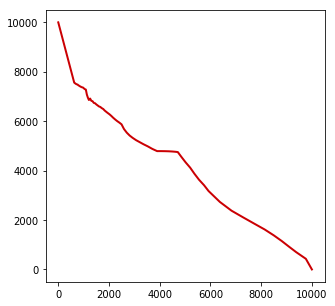

In [94]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(5, 5))
ax.plot(
    100 * np.array([0.0]   + list(100 * np.mean(skm_r, axis=1)[:, 0]) + [100.0]),
    100 * np.array([100.0] + list(100 * np.mean(skm_p, axis=1)[:, 0]) + [0.0]),
    color = "#CB0003",
    linewidth = 2.0
)


In [97]:
np.array([100.0] + list(np.mean(skm_p, axis=1)[:, 0]) + [0.0])

array([  1.00000000e+02,   7.56191222e-01,   7.54302495e-01,
         7.52085141e-01,   7.50288410e-01,   7.48886360e-01,
         7.47959373e-01,   7.45645625e-01,   7.43838732e-01,
         7.41603731e-01,   7.40302584e-01,   7.38013312e-01,
         7.37043072e-01,   7.35765915e-01,   7.32083088e-01,
         7.29685120e-01,   7.27955267e-01,   7.07489765e-01,
         6.95034470e-01,   6.85759150e-01,   6.91591410e-01,
         6.82492166e-01,   6.80934998e-01,   6.74082701e-01,
         6.72539197e-01,   6.68138188e-01,   6.63837930e-01,
         6.59672669e-01,   6.57531894e-01,   6.52991474e-01,
         6.49193788e-01,   6.43379980e-01,   6.38571083e-01,
         6.33384579e-01,   6.27705220e-01,   6.21373202e-01,
         6.14327148e-01,   6.07001953e-01,   6.00500669e-01,
         5.94487632e-01,   5.87355821e-01,   5.68264980e-01,
         5.53731806e-01,   5.42108172e-01,   5.32778006e-01,
         5.23245249e-01,   5.15145853e-01,   5.06746102e-01,
         4.98182795e-01,

In [4]:
none_cv_p = report["none"]["test-CV-F"]["P"]
none_cv_r = report["none"]["test-CV-F"]["R"]
none_cv_f = report["none"]["test-CV-F"]["F"]
none_cv_auprc = report["none"]["test-CV-AUPRC"]["AUPRC"]

all_cv_p = report["all"]["test-CV-F"]["P"]
all_cv_r = report["all"]["test-CV-F"]["R"]
all_cv_f = report["all"]["test-CV-F"]["F"]
all_cv_auprc = report["all"]["test-CV-AUPRC"]["AUPRC"]

print("      P = {:5.2f}% +/- {:5.2f}".format(100*np.mean(none_cv_p), 100*np.std(none_cv_p)))
print("[AUG] P = {:5.2f}% +/- {:5.2f}".format(100*np.mean(all_cv_p), 100*np.std(all_cv_p)))
print("")

print("      R = {:5.2f}% +/- {:5.2f}".format(100*np.mean(none_cv_r), 100*np.std(none_cv_r)))
print("[AUG] R = {:5.2f}% +/- {:5.2f}".format(100*np.mean(all_cv_r), 100*np.std(all_cv_r)))
print("")

print("      F = {:5.2f}% +/- {:5.2f}".format(100*np.mean(none_cv_f), 100*np.std(none_cv_f)))
print("[AUG] F = {:5.2f}% +/- {:5.2f}".format(100*np.mean(all_cv_f), 100*np.std(all_cv_f)))
print("")

print("      AUPRC = {:5.2f}% +/- {:5.2f}".format(100*np.mean(none_cv_auprc), 100*np.std(none_cv_auprc)))
print("[AUG] AUPRC = {:5.2f}% +/- {:5.2f}".format(100*np.mean(all_cv_auprc), 100*np.std(all_cv_auprc)))
print("")

      P = 36.01% +/-  9.82
[AUG] P = 50.40% +/-  3.53

      R = 66.30% +/-  1.91
[AUG] R = 68.42% +/-  1.04

      F = 45.95% +/-  8.39
[AUG] F = 57.95% +/-  2.12

      AUPRC = 51.55% +/-  4.25
[AUG] AUPRC = 62.27% +/-  2.00



In [80]:
report["none"]["test-CV-AUPRC"]["AUPRC"]

array([ 0.54357853,  0.53709737,  0.53360769,  0.53259074,  0.43086302])

In [8]:
scipy.stats.ttest_ind(
    report["none"]["test-CV-AUPRC"]["AUPRC"],
    report["all"]["test-CV-AUPRC"]["AUPRC"])

Ttest_indResult(statistic=-4.5589960730472994, pvalue=0.001852349574801112)

In [12]:
scipy.stats.ttest_ind(
    report["none"]["test-CV-F"]["F"],
    report["all"]["test-CV-F"]["F"])

Ttest_indResult(statistic=-11.468093805441301, pvalue=3.0263535709229697e-06)

In [11]:
report["all"]["validation"]["threshold_ids"].astype('int')

array([[103, 102,  79, 115,   0,  91,   0, 106,   0, 135],
       [205,   0, 207,   0, 189, 170, 206, 193, 191, 184],
       [143,   0, 137, 150,   0, 158,   0, 145, 154, 118],
       [130, 158,   0, 136, 162, 133, 174, 134, 158, 140],
       [134, 131, 203, 126, 140, 131, 123, 121, 125, 139],
       [159, 186, 130, 133, 140, 161, 170, 141, 166, 168]])

In [13]:
report["all"]["validation"]["trials_F"]

array([[4, 8, 9, 6, 3, 0, 2, 1, 5, 7],
       [1, 3, 0, 9, 2, 6, 4, 8, 5, 7],
       [1, 4, 6, 8, 0, 9, 7, 5, 3, 2],
       [2, 9, 1, 5, 6, 3, 4, 8, 7, 0],
       [2, 8, 1, 0, 4, 9, 5, 7, 3, 6],
       [4, 9, 8, 6, 1, 2, 5, 3, 7, 0]])

In [19]:
report["all"]["test-CV-AUPRC"]

{'AUPRC': array([ 0.584095  ,  0.63561248,  0.6339047 ,  0.62212594,  0.63773739]),
 'F': array([[ 0.35295597,  0.42790717,  0.34734553,  0.38978859,  0.46430929],
        [ 0.35295597,  0.42790717,  0.34734553,  0.38978859,  0.46430929],
        [ 0.35295597,  0.42790717,  0.34734553,  0.38978859,  0.46430929],
        ..., 
        [ 0.11722689,  0.12112152,  0.11181427,  0.11352741,  0.11617216],
        [ 0.1094169 ,  0.10481815,  0.10266519,  0.10070289,  0.10740003],
        [ 0.08213971,  0.08110349,  0.081202  ,  0.08133519,  0.08134013]]),
 'P': array([[ 0.68611949,  0.85188925,  0.87925697,  0.81890475,  0.86289395],
        [ 0.68611949,  0.85188925,  0.87925697,  0.81890475,  0.86289395],
        [ 0.68611949,  0.85188925,  0.87925697,  0.81890475,  0.86289395],
        ..., 
        [ 0.0624635 ,  0.06466246,  0.05938754,  0.06034093,  0.06186434],
        [ 0.05803582,  0.05543977,  0.05423996,  0.05313929,  0.05689826],
        [ 0.04289825,  0.04233346,  0.04238703,  0.

array([  0.00000000e+00,   2.20184981e-11,  -4.10745882e-11,
         1.25375266e-11,  -1.51066937e-11,  -2.17206253e-11,
        -4.73776574e-12,   3.87211374e-11,   1.18864918e-11,
         1.83829618e-11,  -3.77222698e-11,   4.81339413e-11,
        -1.89284144e-11,  -3.31641381e-11,   1.18723920e-11,
         2.34132713e-11,   9.57345314e-12,  -2.05421236e-11,
         4.32822667e-11,   1.25094379e-11,   0.00000000e+00,
         2.01845207e-11,  -1.07459597e-11,   2.53754795e-11,
         4.89319696e-11,  -1.72059034e-11,  -4.73768802e-11,
        -1.27885480e-11,   1.88642435e-11,  -1.61706204e-11,
         2.27766694e-11,  -1.86609617e-11,   1.07169829e-11,
        -3.16408011e-11,   1.87233562e-11,   3.41324746e-11,
        -4.26558788e-12,  -5.42155210e-12,   3.28234107e-11,
         2.50939269e-11,   0.00000000e+00,   1.84552373e-12,
        -7.45881135e-12,  -4.62454519e-11,  -1.06806786e-11,
         2.79409829e-11,   2.62314614e-11,  -2.78861378e-11,
        -1.13569154e-11,

In [5]:
# ICASSP CONVNET

import numpy as np
import os
import pandas as pd
import scipy.interpolate
import sklearn.metrics
import sys
sys.path.append("../src")
import localmodule


from matplotlib import pyplot as plt
%matplotlib inline

# Define constants.
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
n_thresholds = 221
n_trials = 10
n_eval_trials = 5


# Initialize dicts.
report = {}


# Loop over augmentations.
for aug_kind_str in ["none", "all"]:

    # Define thresholds
    thresholds = 1.0 - np.concatenate((
        np.logspace(-9, -2, 141), np.delete(np.logspace(-2, 0, 81), 0)
    ))
    n_thresholds = len(thresholds)


    # Define model directory
    model_name = "pcen-convnet"
    if not aug_kind_str == "none":
        model_name = "_".join([model_name, "aug-" + aug_kind_str])
    model_dir = os.path.join(models_dir, model_name)


    # Loop over test units.
    for test_unit_id in range(n_units):

        test_unit_str = units[test_unit_id]
        test_unit_dir = os.path.join(model_dir, test_unit_str)

        # Retrieve fold such that unit_str is in the test set.
        folds = localmodule.fold_units()
        fold = [f for f in folds if test_unit_str in f[0]][0]
        test_units = fold[0]
        validation_units = fold[2]


        val_losses = []
        for trial_id in range(n_trials):
            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)
            history_name = "_".join([
                dataset_name,
                model_name,
                test_unit_str,
                trial_str,
                "history.csv"
            ])
            history_path = os.path.join(
                trial_dir, history_name)
            try:
                history_df = pd.read_csv(history_path)
                val_loss = min(history_df["Validation loss"])
            except:
                val_loss = np.inf
            val_losses.append(val_loss)

        val_losses = np.array(val_losses)
        best_trial_id = np.argmin(val_losses)
        best_trial_str = "trial-" + str(best_trial_id)
        trial_dir = os.path.join(test_unit_dir, best_trial_str)

        # Load test predictions.
        test_metrics_name = "_".join([
            dataset_name,
            model_name,
            "test-" + test_unit_str,
            best_trial_str,
            "predict-" + test_unit_str,
            "full-audio-metrics.csv"
        ])
        test_metrics_path = os.path.join(trial_dir, test_metrics_name)
        test_metrics_df = pd.read_csv(test_metrics_path)
        test_tp = test_tp + np.array(test_metrics_df["True positives"])
        test_fp = test_fp + np.array(test_metrics_df["False positives"])
        test_fn = test_fn + np.array(test_metrics_df["False negatives"])

        test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
        test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
        test_p_ = np.array([1.0] + list(test_p) + [0.0])
        test_r_ = np.array([0.0] + list(test_r) + [1.0])
        test_auprc = sklearn.metrics.auc(test_r_, test_p_, reorder=True)

        plt.figure()
        plt.plot(test_r_, test_p_)

EmptyDataError: No columns to parse from file

In [6]:
test_metrics_path

'/scratch/vl1019/BirdVox-70k_models/pcen-convnet/unit01/trial-2/BirdVox-70k_pcen-convnet_test-unit01_trial-2_predict-unit01_full-audio-metrics.csv'